# Problem Set 5
## [Submitted by Zhihan Yu]

### Problem 1 (a)
Plotting the data.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

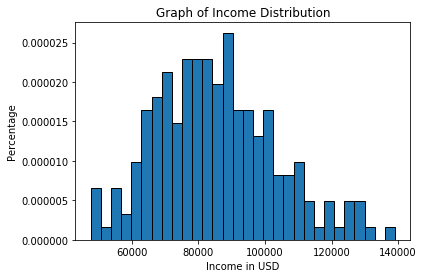

In [2]:
# Load the data as a NumPy array
incomes_dat = np.loadtxt('data/incomes.txt')

# Plot the histogram with 30 bins
plt.hist(incomes_dat, bins=30, density=True, edgecolor='black')
plt.xlabel("Income in USD")
plt.ylabel("Percentage")
plt.title("Graph of Income Distribution")
plt.show()

### Problem 1 (b)
I wish to estimate the parameters $\sigma$ and $\mu$ of log-normal distribution. Specifically, I'll be using the mean and the standard deviation:
$$ mean(income_i) = \frac{1}{N}\sum_{i=1}^N income_i $$

$$ stdev^2(income_i) = var(income_i) = \frac{1}{N}\sum_{i=1}^{N} \left(income_i - mean(income_i)\right)^2 $$

Furthermore, I'll be using the identity matrix as the weighting matrix. Therefore, the GMM estimator is:
$$ (\hat{\mu}_{GMM},\hat{\sigma}_{GMM}) = (\mu,\sigma):\quad \min_{\mu,\sigma} e(income_i|\mu,\sigma)^T \, I \, e(income_i|\mu,\sigma) $$


In [3]:
def LN_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function gives the PDF of the lognormal distribution for xvals
    given mu and sigma

    (LN): f(x; mu, sigma) = (1 / (x * sigma * sqrt(2 * pi))) *
            exp((-1 / 2) * (((log(x) - mu) / sigma) ** 2))
            x in [0, infty), mu in (-infty, infty), sigma > 0
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, data
    mu    = scalar, mean of the ln(x)
    sigma = scalar > 0, standard deviation of ln(x)

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals        = (N,) vector, probability of each observation given
                      the parameter values

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    pdf_vals = np.float64(((1 / (np.sqrt(2 * np.pi) * sigma * xvals)) *
                          np.exp((-1.0 / 2.0) *
                          (((np.log(xvals) - mu) / sigma) ** 2))))

    return pdf_vals

To proceed, we need to obtain the moments ($\mu$ and $\sigma$) that's generated from the data and from the model. Since we are working with the log normal distribution, the first moment (mean) and second moment (variance) of the distribution is defined as follows (from Wikipedia):

$$mean_{lognorm} = exp(\mu + \frac{\sigma^2}{2})$$
$$var_{lognorm} = exp(\sigma^2-1)*exp(2\mu + \sigma^2)$$

In [4]:
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt

# Moments from data
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    std_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, std_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

# Moments from model
def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function gives the two data moments for the lognormal
    distribution (mean and standard deviation)
    --------------------------------------------------------------------
    INPUTS:
    mu = float, mean of the lognormal distribution
    sigma = float, standard deviation of the lognormal deviation
    
    RETURNS: mean_model, std_model
    '''
    mean_model = np.exp(mu + 0.5*sigma**2)
    std_model = np.sqrt((np.exp(sigma**2)-1) * np.exp(2*mu+sigma**2))
    return mean_model, std_model

Now we define the error function that is characterized by the following formula:

$$ e(income_i|\mu,\sigma) \equiv \frac{m(income_i|\mu,\sigma) - m(scores_i)}{m(income_i)} $$

In [5]:
def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    std_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    std_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

Now we have all the infrastructure set. And we will run the model given the intial settings.

In [6]:
# Run the model
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes_dat, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
results
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.33188086698309  sig_GMM1= 0.2086966524682645


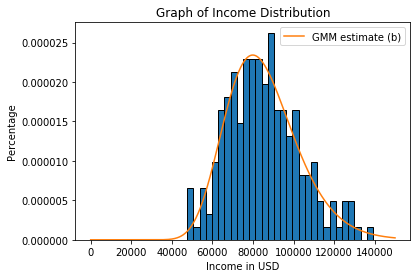

mean_GMM1= 85276.825; standardDev_GMM1= 17992.542
mean_data= 85276.824; standardDev_data= 17992.542
Error:  [ 2.12961363e-08 -2.34875480e-08]
GMM criterion function: [[1.00519033e-15]]


In [7]:
income_range = np.linspace(0.01, 150000, 30000)

plt.hist(incomes_dat, bins=30, density=True, edgecolor='black')
plt.xlabel("Income in USD")
plt.ylabel("Percentage")
plt.title("Graph of Income Distribution")
plt.plot(income_range, LN_pdf(income_range, mu_GMM1, sig_GMM1), label=r"GMM estimate (b)")
plt.legend()
plt.show()

mean_model1, std_model1 = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(incomes_dat, mu_GMM1, sig_GMM1, False).reshape(2,)

# Reporting the model moments and data moments
mean_data, std_data = data_moments(incomes_dat)

print('mean_GMM1= %0.3f; standardDev_GMM1= %0.3f' %(mean_model1, std_model1))
print('mean_data= %0.3f; standardDev_data= %0.3f'%(mean_data, std_data))
print('Error: ', err1)
print('GMM criterion function:',results.fun)

It should not be suprising to see that the model momemnts and the data moments match up almost exactly at the $10^{-3}$ precision level. This is because we manually set the minimization tolarnce to be very low (at $10^{-14}$).

### Problem 1(c)
Using the code from class,we need to define a new weighting matrix W. 

In [8]:
def get_Err_mat2(dat, mu, sigma, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded
    R = 2.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    R          = integer = 2, hard coded number of moments
    N          = integer >= R, number of data observations
    Err_mat    = (R, N) matrix, error by moment and observation data
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: Err_mat
    --------------------------------------------------------------------
    '''
    R = 2
    N = len(dat)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma)
    if simple:
        Err_mat[0, :] = dat - mean_model
        Err_mat[1, :] = ((mean_data - dat) ** 2) - var_model
    else:
        Err_mat[0, :] = (dat - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - dat) ** 2) - var_model) / var_model
    
    return Err_mat

Err_mat = get_Err_mat2(incomes_dat, mu_GMM1, sig_GMM1, False)
VCV2 = (1 / incomes_dat.shape[0]) * (Err_mat @ Err_mat.T)
print("Variance Co-Variance Matrix: \n", VCV2)
W_hat2 = np.linalg.inv(VCV2)
print("New weighting matrix: \n", W_hat2)

Variance Co-Variance Matrix: 
 [[4.45167045e-02 1.68385256e+03]
 [1.68385256e+03 9.54184435e+08]]
New weighting matrix: 
 [[ 2.40701670e+01 -4.24767065e-05]
 [-4.24767065e-05  1.12297421e-09]]


Now that we have the new weighting matrix *W_hat2*, we'll do the exact same exercise as before. 

In [9]:
# mu_init = 11 (No need to redefine global)
# sig_init = 0.5 (No need to redefine global)
params_init = np.array([mu_GMM1, sig_GMM1]) 
gmm_args = (incomes_dat, W_hat2) # Only changed W_hat2 arg.
results2= opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM1= 11.33188086698309  sig_GMM1= 0.2086966524682645
mu_GMM2= 11.331880842298686  sig_GMM2= 0.20869664809200128


mean_GMM1= 85276.825; standardDev_GMM1= 17992.542
mean_GMM2= 85276.823; standardDev_GMM2= 17992.541
mean_data= 85276.824; standardDev_data= 17992.542


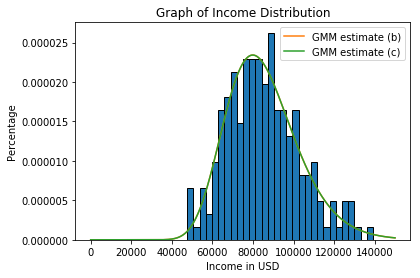

Error2:  [-4.30157821e-09 -7.05147256e-08]
GMM2 criterion function: [[4.4535838e-16]]


In [10]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2)
# Reporting the model moments and data moments

print('mean_GMM1= %0.3f; standardDev_GMM1= %0.3f' %(mean_model1, std_model1))
print('mean_GMM2= %0.3f; standardDev_GMM2= %0.3f' %(mean_model2, std_model2))
print('mean_data= %0.3f; standardDev_data= %0.3f'%(mean_data, std_data))

plt.hist(incomes_dat, bins=30, density=True, edgecolor='black')
plt.xlabel("Income in USD")
plt.ylabel("Percentage")
plt.title("Graph of Income Distribution")
plt.plot(income_range, LN_pdf(income_range, mu_GMM1, sig_GMM1), label=r"GMM estimate (b)")
plt.plot(income_range, LN_pdf(income_range, mu_GMM2, sig_GMM2), label=r"GMM estimate (c)")
plt.legend()
plt.show()
err2 = err_vec(incomes_dat, mu_GMM2, sig_GMM2, False).reshape(2,)
print('Error2: ', err2)
print('GMM2 criterion function:',results2.fun)

Using a different weighting matrix did seem to make the error lower (eyeballing it--smaller first element while the second element didnt change much.). More concretely, we can just compare the values of the criterion function: the GMM1 Criterion function was on the magnitude of $10^{-16}$, while GMM2 Criterion function is on $10^{-17}$.

### Problem 1(d)
We need to redefine the data and model moments.

In [11]:
# Generate data moments
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 100000 <= x 

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3, bpct_4
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

# Use the previous function of lognorm cdf. The cdf formula is obtained from wikipedia
from scipy.special import erf
def lognormalcdf(x, mu, sig):
    err_msg = "standard dev. must be positive"
    assert sig > 0, err_msg
        
    err_msg = "input must be positive"
    if type(x) == np.array or type(x) == np.ndarray:
        assert x.all() > 0, err_msg2
    elif type(x) == int or type(x) == float:
        assert x > 0, err_msg2
    
    inerf = (np.log(x) - mu) / (sig * (2 ** 0.5))
    rtnval = 0.5 + 0.5 * erf(inerf)
    
    return rtnval


# Find the probabilities of falling in each interval.
## * Note since we know the exact functional form of the cdf, i'll not use to .quad method....that's inefficient and unecessary. 
def model_moments3(mu, sigma):
    bpct_1_mod = lognormalcdf(75000, mu, sigma)
    bpct_2_mod = lognormalcdf(100000, mu, sigma) - bpct_1_mod
    bpct_3_mod = 1 - lognormalcdf(100000, mu, sigma) 
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

Likewise, we need to redefine the error function and criterion function.

In [12]:
def err_vec3(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments3()
        model_moments3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [13]:
params = np.array([mu_GMM1, sig_GMM1])
print('params from before=', params)
print("Data Moments: ", data_moments3(incomes_dat))
print("Model Moments: ",model_moments3(mu_GMM1, sig_GMM1))
print("Criterion using params so far (part b): ", criterion3(params, incomes_dat, np.eye(3)))

params from before= [11.33188087  0.20869665]
Data Moments:  (0.3, 0.5, 0.2)
Model Moments:  (0.30468645806045114, 0.5024798166693349, 0.19283372527021392)
Criterion using params so far (part b):  [[0.00155252]]


Now let's run the minimization. 

In [14]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (incomes_dat,W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
print('Data moments are: ', data_moments3(incomes_dat))
print('Model moments using mu_GMM1_3, sig_GMM1_3  are: ', model_moments3(mu_GMM1_3, sig_GMM1_3))

mu_GMM1_3= 11.335681325705682  sig_GMM1_3= 0.21059845293913249
Data moments are:  (0.3, 0.5, 0.2)
Model moments using mu_GMM1_3, sig_GMM1_3  are:  (0.30000000579420316, 0.5000000068525199, 0.19999998735327695)


Just looking at the data moments and the model moments, we see that they are awefully close to one another. Let's graph it and see it. Also, we'll look at the errors and criterion functions at this optimized vector of paramters.

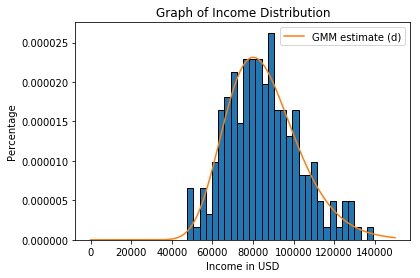

Error1_3:  [ 1.93140106e-08  1.37050398e-08 -6.32336153e-08]
GMM1_3 criterion function: [[4.55934922e-15]]


In [15]:
plt.hist(incomes_dat, bins=30, density=True, edgecolor='black')
plt.xlabel("Income in USD")
plt.ylabel("Percentage")
plt.title("Graph of Income Distribution")
# plt.plot(income_range, LN_pdf(income_range, mu_GMM1, sig_GMM1), label=r"GMM estimate (b)")
# plt.plot(income_range, LN_pdf(income_range, mu_GMM2, sig_GMM2), label=r"GMM estimate (c)")
plt.plot(income_range, LN_pdf(income_range, mu_GMM1_3, sig_GMM1_3), label=r"GMM estimate (d)")
plt.legend()
plt.show()

err1_3 = err_vec3(incomes_dat, mu_GMM1_3, sig_GMM1_3, False).reshape(3,)
print('Error1_3: ', err1_3)
print('GMM1_3 criterion function:',results_3.fun)

Visually from the graph, its very hard for us to see any significant difference between parts (b) and (c)...But, if use the parameters from (b) to estimate these three moments we see that the value of the criterion function is 0.00155252 (on the magnitude of $10^{-4})$. But, 'correcting' the parameters by performing a GMM estimation, we arrive with the value of the criterion function to be on the magnitude of $10^{-16}$.This is a very significant change!

### Problem 1(e)
First, we need to set up the new weight matrix.

In [16]:
def get_Err_mat3(pts, mu, sigma, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded
    R = 3.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    R          = 3, hard coded number of moments
    N          = integer >= R, number of data observations
    Err_mat    = (R, N) matrix, error by moment and observation data
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: Err_mat
    --------------------------------------------------------------------
    '''
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments3(mu, sigma)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [17]:
Err_mat3 = get_Err_mat3(incomes_dat, mu_GMM1_3, sig_GMM1_3, True)
VCV2_3 = (1 / incomes_dat.shape[0]) * (Err_mat3 @ Err_mat3.T)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = np.linalg.pinv(VCV2_3)

print("Variance Co-Variance Matrix: \n", VCV2_3)
print("New weighting matrix: \n", W_hat2_3)

Variance Co-Variance Matrix: 
 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]
New weighting matrix: 
 [[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


Optimize again!

In [18]:
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (incomes_dat,W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)
print("Criterion using params so far (part e): ", results2_3.fun)
print('Data moments are: ', data_moments3(incomes_dat))
print('Model moments using mu_GMM2_3, sig_GMM2_3  are: ', model_moments3(mu_GMM2_3, sig_GMM2_3))

mu_GMM2_3= 11.335681325705682  sig_GMM2_3= 0.21059845293913249
Criterion using params so far (part e):  [[1.81400558e-14]]
Data moments are:  (0.3, 0.5, 0.2)
Model moments using mu_GMM2_3, sig_GMM2_3  are:  (0.30000000579420316, 0.5000000068525199, 0.19999998735327695)


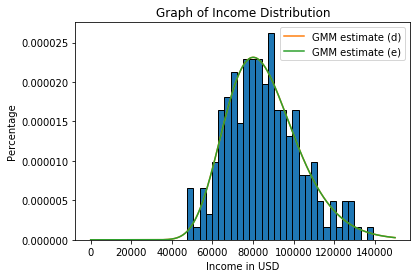

In [19]:
plt.hist(incomes_dat, bins=30, density=True, edgecolor='black')
plt.xlabel("Income in USD")
plt.ylabel("Percentage")
plt.title("Graph of Income Distribution")
plt.plot(income_range, LN_pdf(income_range, mu_GMM1_3, sig_GMM1_3), label=r"GMM estimate (d)")
plt.plot(income_range, LN_pdf(income_range, mu_GMM2_3, sig_GMM2_3), label=r"GMM estimate (e)")
plt.legend()
plt.show()

### Problem 1(f)
When we select the 'best' model, I it's intuitive to look for the model that yields the lowest value of the criterion function (since we were trying to minimize this). This would point to the result in part (c). This has a criterion value of on the magnitude of $10^{-17})$. 

## Problem 2
Since we are doing a GMM on this linear model, we have 4 criterions to estimate [b0, b1, b2, b3]. It is basically a replication of what we've done in part one, except we use the normal distribution of errors as our 'reference'. 

In [20]:
import pandas as pd
sick_dat = pd.read_csv("data/sick.txt")

# Define Error
def err_vecOLS(data, b0, b1, b2, b3):
    
    err_vec = data['sick'] - (b0 + b1 * data['age'] + b2 * data['children'] + b3 * data['avgtemp_winter'])
    
    return err_vec

# Define criterion
def criterionOLS(params, *args):

    b0, b1, b2, b3 = params
    data, W = args
    err_vec = err_vecOLS(data, b0, b1, b2, b3)
    crit_val = err_vec.T @ W @ err_vec
    
    return crit_val

We could use an agnostic initialization point, but I will try to do the linear regression to give myself an idea of what to do. 

In [21]:
from sklearn.linear_model import LinearRegression

y = np.array(sick_dat['sick'])
x = np.array(sick_dat[['age', 'children', 'avgtemp_winter']])
lin_reg = LinearRegression().fit(x, y)
betas = np.append(np.array(lin_reg.intercept_), lin_reg.coef_)

for i in range(4):
    print('OLSbeta_%s = '%(i), betas[i])

OLSbeta_0 =  0.25164137472290005
OLSbeta_1 =  0.012933658720611065
OLSbeta_2 =  0.40049939478133745
OLSbeta_3 =  -0.009991743362244121


From the linear regression, we see that we can initialize b0, b1, b2, b3 as: (0.25, 0.01, 0.40, 0.00)

In [22]:
b0, b1, b2, b3 = (0.25, 0.01, 0.40, 0.00)
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(sick_dat.shape[0])
gmm_args = (sick_dat, W_hat)
results = opt.minimize(criterionOLS, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
b0_GMM, b1_GMM, b2_GMM, b3_GMM = results.x

print('beta_0 =', b0_GMM)
print('beta_1 =', b1_GMM)
print('beta_2 =', b2_GMM)
print('beta_3 =', b3_GMM)
print('GMM criterion function:',results.fun)

beta_0 = 0.2516447361214882
beta_1 = 0.012933451571115355
beta_2 = 0.4005011755376142
beta_3 = -0.009991696166433153
GMM criterion function: 0.001821289817216178


We see that the values are VERY close to one another. We're happy. 